275.4539748953975


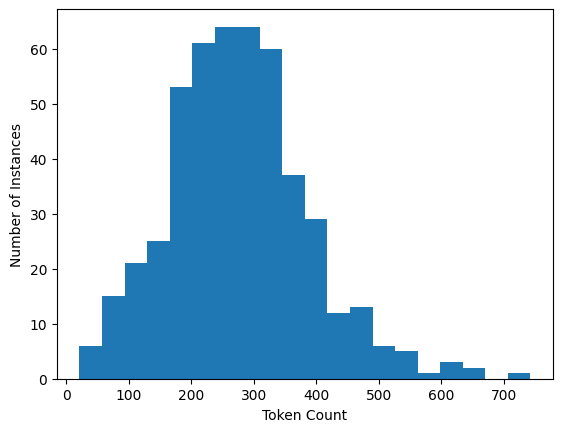

In [2]:
import tiktoken
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

token_count = []
for abstract in pd.read_pickle('../../datasets/mrst_abstracts_embedding.pkl')['content']:
    token = num_tokens_from_string(abstract, "cl100k_base")
    if token and token < 1000:
        token_count.append(token)

n_bins = 20
minimum, maximum = min(token_count), max(token_count)
log_bins = np.logspace(np.log10(minimum), np.log10(maximum), n_bins+1, base = 10)

print(sum(token_count)/len(token_count))
plt.hist(token_count, bins = n_bins)
# plt.hist(token_count, bins = log_bins)
plt.xlabel('Token Count')
plt.ylabel('Number of Instances')
# plt.xscale('log')
plt.savefig('mrst_abstract_token_count.svg')

In [ ]:
from openai import OpenAI
import os
from dotenv import load_dotenv
from pydantic import BaseModel
from typing import List
import requests
from bs4 import BeautifulSoup
import json

load_dotenv()
api_key = os.getenv("LANGCHAIN_OPENAI_API_KEY")

client = OpenAI(api_key=api_key)

def web_search_mrst(filename: str) -> tuple[str, List[str]]:
    """Scrape a SINTEF MRST website with filename,
    and return content and explicit links to other mrst sites"""
    try:
        response = requests.get(filename)
        soup = BeautifulSoup(response.content, 'html.parser')
        text = soup.get_text(strip = True)
        links = ["https://sintef.no" + l['href'] for l in soup.find_all('a', href = True) if l['href'][0]=="/"]
        return (text, links)
    except Exception as e:
        print(e)
        return ("",[])

class Keywords(BaseModel):
    keywords: List[str]

instructions = f"""
You are an expert reservoir simulation petroleum scientist for the MRST group at Sintef.
Generate 10 keywords about the research topics mentioned in the users query.
Always use the tools call, here are some possible start links:
{[link for link in web_search_mrst('https://www.sintef.no/projectweb/mrst/modules/')[1] if 'modules' in link]}
"""

question = "What do you know about enhanced oil recovery"

tools = [
    {
        "type": "function",
        "name": "web_search_mrst",
        "description": "Scrape Sintef MRST module site to learn more about specific Matlab Reservoir Simulation Toolbox Modules",
        "parameters": {
            "type": "object",
            "properties": {
                "filename": {
                    "type": "string",
                    "description": "The Web Page you want to learn information from"
                }
            },
            "required": ["filename"]
        }
    }
]

input_messages = [
    {"role": "developer", "content": instructions}, {"role": "user", "content": question}
]

# response = client.responses.create(
#     model="gpt-5-nano",
#     tools=tools,
#     instructions=instructions,
#     input=input_messages,
#     # text_format = Keywords
# )

# function_call = None
# function_call_arguments = None
# input_messages += response.output

# for item in response.output:
#     if item.type == "function_call":
#         function_call = item
#         function_call_arguments = json.loads(item.arguments)
#         print(item)